In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from shapely.geometry import Point
from shapely.geometry import shape
import seaborn as sns
from datetime import datetime, timedelta
import os
from zipfile import ZipFile
import random
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

In [2]:
## ================================================== Read file and data preprocess ==========================================##

In [3]:
# read station information
station_info = pd.read_csv('Data/stationinfo/station_info.csv')
station_info['geometry'] = station_info[['longitude', 'latitude']].values.tolist()
station_info['geometry'] = station_info['geometry'].apply(Point)

# select those bike stations within DC 
DC_road_info = gpd.read_file('Data/Shapefile/Roads.geojson')
DC_boundary = gpd.read_file('Data/Shapefile/Washington_DC_Boundary.geojson')
DC_station_index = []
for i in range (len(station_info)):
    if station_info.geometry[i].within(DC_boundary.geometry[0]):
        DC_station_index.append(i)
station_info = station_info.loc[DC_station_index]

# read bikeshare data in 2019
# Open the zip file in read-only mode.
directory = "Data/Bikesharedata/"
file_paths = []
# crawling through directory and subdirectories
for root, directories, files in os.walk(directory):
    for filename in files:
        # join the two strings in order to form the full filepath.
        filepath = os.path.join(root, filename)
        file_paths.append(filepath)

sharingbikedata = []

for i in range (len(file_paths)):
    file_path = file_paths[i]
    archive = ZipFile(file_path, "r")
    trip_data = pd.read_csv(archive.open(archive.namelist()[0]))
    sharingbikedata.append(trip_data)

sharingbikedata = pd.concat(sharingbikedata, ignore_index = True)
sharingbikedata = sharingbikedata[sharingbikedata['Start station number'].isin(station_info.station_id.unique())]
sharingbikedata = sharingbikedata[sharingbikedata['End station number'].isin(station_info.station_id.unique())]


# add start_station_info into sharingbikedata
sharingbikedata = sharingbikedata.merge(station_info,
                                        how = 'left',
                                       left_on = 'Start station number',
                                       right_on = 'station_id')
sharingbikedata = sharingbikedata.rename(columns = {"latitude": "start_lat",
                                                   "longitude": "start_lon",
                                                   "geometry": "start_geo"})

# add end_station_info into sharingbikedata
sharingbikedata = sharingbikedata.merge(station_info,
                                        how = 'left',
                                       left_on = 'End station number',
                                       right_on = 'station_id')
sharingbikedata = sharingbikedata.rename(columns = {"latitude": "end_lat",
                                                   "longitude": "end_lon",
                                                   "geometry": "end_geo"})

sharingbikedata = sharingbikedata.drop(columns = {"station_id_x", "station_id_y", "Start station", "End station", "Bike number", "Member type", "start_lat", "start_lon", "end_lat", "end_lon"}, axis = 1)
sharingbikedata.head()

,Duration,Start date,End date,Start station number,End station number,start_geo,end_geo
0,230,2019-01-01 00:04:48,2019-01-01 00:08:39,31203,31200,POINT (-77.03230426292606 38.90859789247971),POINT (-77.04439437680891 38.91010276338776)
1,1549,2019-01-01 00:06:37,2019-01-01 00:32:27,31321,31114,POINT (-77.03323264662363 38.89224468680707),POINT (-77.04156933406961 38.91880522982117)
2,177,2019-01-01 00:08:46,2019-01-01 00:11:44,31104,31323,POINT (-77.04251684149087 38.92286480915612),POINT (-77.05183042603885 38.92339171298058)
3,228,2019-01-01 00:08:47,2019-01-01 00:12:35,31281,31280,POINT (-77.02277550199454 38.90863746501813),POINT (-77.02703157099604 38.91375645994466)
4,1202,2019-01-01 00:12:50,2019-01-01 00:32:53,31618,31269,POINT (-77.00035104474399 38.88995516161965),POINT (-77.00195738745647 38.88737544448145)


In [4]:
# compute travel distance (km)
origin_geo = gpd.GeoDataFrame({'geometry': sharingbikedata.start_geo}, crs='EPSG:4326').to_crs('EPSG:5234')
destination_geo = gpd.GeoDataFrame({'geometry': sharingbikedata.end_geo}, crs='EPSG:4326').to_crs('EPSG:5234')
sharingbikedata['Distance'] = origin_geo.distance(destination_geo)/1000

# compute travel time (min)
sharingbikedata['Duration'] = sharingbikedata['Duration']/60

sharingbikedata.head()

,Duration,Start date,End date,Start station number,End station number,start_geo,end_geo,Distance
0,3.833333,2019-01-01 00:04:48,2019-01-01 00:08:39,31203,31200,POINT (-77.03230426292606 38.90859789247971),POINT (-77.04439437680891 38.91010276338776),1.110814
1,25.816667,2019-01-01 00:06:37,2019-01-01 00:32:27,31321,31114,POINT (-77.03323264662363 38.89224468680707),POINT (-77.04156933406961 38.91880522982117),3.175886
2,2.950000,2019-01-01 00:08:46,2019-01-01 00:11:44,31104,31323,POINT (-77.04251684149087 38.92286480915612),POINT (-77.05183042603885 38.92339171298058),0.847059
3,3.800000,2019-01-01 00:08:47,2019-01-01 00:12:35,31281,31280,POINT (-77.02277550199454 38.90863746501813),POINT (-77.02703157099604 38.91375645994466),0.708914
4,20.033333,2019-01-01 00:12:50,2019-01-01 00:32:53,31618,31269,POINT (-77.00035104474399 38.88995516161965),POINT (-77.00195738745647 38.88737544448145),0.333231


In [5]:
print(len(sharingbikedata))
sharingbikedata[["Duration", "Distance"]].describe()

2874732


,Duration,Distance
count,2.874732e+06,2.874732e+06
mean,1.751354e+01,1.797798e+00
std,3.599026e+01,1.183448e+00
min,1.000000e+00,0.000000e+00
25%,6.683333e+00,9.487935e-01
50%,1.128333e+01,1.551856e+00
75%,1.873333e+01,2.417858e+00
max,1.439417e+03,1.814288e+01


In [6]:
## add start hour and day
sharingbikedata['Start date'] = pd.to_datetime(sharingbikedata['Start date'])
sharingbikedata['start_month'] = sharingbikedata["Start date"].dt.month
sharingbikedata['start_day'] = sharingbikedata["Start date"].dt.day
sharingbikedata['start_hour'] = sharingbikedata["Start date"].dt.hour
sharingbikedata['End date'] = pd.to_datetime(sharingbikedata['End date'])
sharingbikedata['end_month'] = sharingbikedata["End date"].dt.month
sharingbikedata['end_day'] = sharingbikedata["End date"].dt.day
sharingbikedata['end_hour'] = sharingbikedata["End date"].dt.hour
sharingbikedata.head()

,Duration,Start date,End date,Start station number,End station number,start_geo,end_geo,Distance,start_month,start_day,start_hour,end_month,end_day,end_hour
0,3.833333,2019-01-01 00:04:48,2019-01-01 00:08:39,31203,31200,POINT (-77.03230426292606 38.90859789247971),POINT (-77.04439437680891 38.91010276338776),1.110814,1,1,0,1,1,0
1,25.816667,2019-01-01 00:06:37,2019-01-01 00:32:27,31321,31114,POINT (-77.03323264662363 38.89224468680707),POINT (-77.04156933406961 38.91880522982117),3.175886,1,1,0,1,1,0
2,2.950000,2019-01-01 00:08:46,2019-01-01 00:11:44,31104,31323,POINT (-77.04251684149087 38.92286480915612),POINT (-77.05183042603885 38.92339171298058),0.847059,1,1,0,1,1,0
3,3.800000,2019-01-01 00:08:47,2019-01-01 00:12:35,31281,31280,POINT (-77.02277550199454 38.90863746501813),POINT (-77.02703157099604 38.91375645994466),0.708914,1,1,0,1,1,0
4,20.033333,2019-01-01 00:12:50,2019-01-01 00:32:53,31618,31269,POINT (-77.00035104474399 38.88995516161965),POINT (-77.00195738745647 38.88737544448145),0.333231,1,1,0,1,1,0


In [7]:
## ================================================ Read Station_info information =========================================##

In [8]:
# Read station_info with attributes
station_info = pd.read_csv('Data/Stationinfo/station_info_attribute.csv')
station_info['geometry'] = station_info[["longitude", "latitude"]].values.tolist()
station_info['geometry'] = station_info['geometry'].apply(Point)
station_info = gpd.GeoDataFrame(station_info)

DC_station_index = []
for i in range (len(station_info)):
    if station_info.geometry[i].within(DC_boundary.geometry[0]):
        DC_station_index.append(i)
station_info = station_info.loc[DC_station_index]

station_info['Bike_Stop'] = 'Bike_Stop' 
station_info = station_info.drop(columns = {'start_ridership', 'end_ridership'}, axis = 1)
station_info.head()

,station_id,latitude,longitude,geometry,TRACTCE,pop_den,male_ratio,housing_unit_den,LU_diversity,bike_density,Bike_Stop
0,31100.0,38.900289,-77.042902,POINT (-77.04290 38.90029),10700,0.001615,0.467361,0.001530,1.410208,0.519472,Bike_Stop
1,31101.0,38.917766,-77.032083,POINT (-77.03208 38.91777),4300,0.014014,0.440458,0.010089,2.515274,0.406192,Bike_Stop
2,31102.0,38.929463,-77.027821,POINT (-77.02782 38.92946),3000,0.013170,0.409156,0.007601,1.914395,0.229339,Bike_Stop
3,31104.0,38.922865,-77.042517,POINT (-77.04252 38.92286),3901,0.017918,0.405918,0.014953,2.041013,0.249042,Bike_Stop
4,31105.0,38.926792,-77.032203,POINT (-77.03220 38.92679),3000,0.013170,0.409156,0.007601,1.914395,0.229339,Bike_Stop


In [9]:
# add transit stop into station_info_attribute
transit_stop_info = pd.read_csv("Data/Shapefile/stops.txt")
transit_stop_info['geometry'] = transit_stop_info[["stop_lon", "stop_lat"]].values.tolist()
transit_stop_info['geometry'] = transit_stop_info['geometry'].apply(Point)
transit_stop_info = gpd.GeoDataFrame(transit_stop_info)

DC_station_index = []
for i in range (len(transit_stop_info)):
    if transit_stop_info.geometry[i].within(DC_boundary.geometry[0]):
        DC_station_index.append(i)
transit_stop_info = transit_stop_info.loc[DC_station_index]

stop_geometry = gpd.GeoDataFrame({'geometry': transit_stop_info['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
station_geometry = gpd.GeoDataFrame({'geometry': station_info['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
stop_nearby_num = np.zeros(len(station_geometry))
for i in range (len(station_geometry)):
    for j in range (len(stop_geometry)):
        if station_geometry.iloc[i][0].distance(stop_geometry.iloc[j][0])/1000 < 0.5: # threshold = 500 m
            stop_nearby_num[i] += 1
station_info['male_ratio'] = stop_nearby_num
station_info = station_info.rename(columns = {"male_ratio": "transit_stop_num"})
station_info.head()

,station_id,latitude,longitude,geometry,TRACTCE,pop_den,transit_stop_num,housing_unit_den,LU_diversity,bike_density,Bike_Stop
0,31100.0,38.900289,-77.042902,POINT (-77.04290 38.90029),10700,0.001615,37.0,0.001530,1.410208,0.519472,Bike_Stop
1,31101.0,38.917766,-77.032083,POINT (-77.03208 38.91777),4300,0.014014,25.0,0.010089,2.515274,0.406192,Bike_Stop
2,31102.0,38.929463,-77.027821,POINT (-77.02782 38.92946),3000,0.013170,41.0,0.007601,1.914395,0.229339,Bike_Stop
3,31104.0,38.922865,-77.042517,POINT (-77.04252 38.92286),3901,0.017918,16.0,0.014953,2.041013,0.249042,Bike_Stop
4,31105.0,38.926792,-77.032203,POINT (-77.03220 38.92679),3000,0.013170,31.0,0.007601,1.914395,0.229339,Bike_Stop


In [10]:
# update start_ridership and end_ridership info in station_info_attribute
station_ridership_start = pd.DataFrame(sharingbikedata[['Start station number']].value_counts()).reset_index()
station_info = station_info.merge(station_ridership_start,
                                  how = 'left',
                                  left_on = 'station_id',
                                  right_on = 'Start station number')
#station_hour_data_end['ridership'] = station_ridership_start.iloc[:,[1]]
station_ridership_end = pd.DataFrame(sharingbikedata[['End station number']].value_counts()).reset_index()
station_info = station_info.merge(station_ridership_end,
                                  how = 'left',
                                  left_on = 'station_id',
                                  right_on = 'End station number')
station_info = station_info.drop(columns = {"Start station number", "End station number"}, axis = 1)
station_info = station_info.rename(columns={'0_x': "start_ridership", '0_y': "end_ridership"})
station_info.start_ridership = station_info.start_ridership/365
station_info.end_ridership = station_info.end_ridership/365
station_info.head()

,station_id,latitude,longitude,geometry,TRACTCE,pop_den,transit_stop_num,housing_unit_den,LU_diversity,bike_density,Bike_Stop,start_ridership,end_ridership
0,31100.0,38.900289,-77.042902,POINT (-77.04290 38.90029),10700,0.001615,37.0,0.001530,1.410208,0.519472,Bike_Stop,18.693151,19.457534
1,31101.0,38.917766,-77.032083,POINT (-77.03208 38.91777),4300,0.014014,25.0,0.010089,2.515274,0.406192,Bike_Stop,71.821918,86.057534
2,31102.0,38.929463,-77.027821,POINT (-77.02782 38.92946),3000,0.013170,41.0,0.007601,1.914395,0.229339,Bike_Stop,37.109589,21.336986
3,31104.0,38.922865,-77.042517,POINT (-77.04252 38.92286),3901,0.017918,16.0,0.014953,2.041013,0.249042,Bike_Stop,48.249315,40.958904
4,31105.0,38.926792,-77.032203,POINT (-77.03220 38.92679),3000,0.013170,31.0,0.007601,1.914395,0.229339,Bike_Stop,23.663014,9.512329


In [11]:
station_info.describe()

,station_id,latitude,longitude,TRACTCE,pop_den,transit_stop_num,housing_unit_den,LU_diversity,bike_density,start_ridership,end_ridership
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,303.000000,302.000000
mean,31435.789773,38.904489,-77.018213,58935.784091,0.005540,21.406250,0.003612,1.946706,0.290042,25.993327,26.079398
std,229.379831,0.026256,0.031257,220346.598151,0.004546,11.293407,0.003703,0.434835,0.224606,22.131713,23.447096
min,31100.000000,38.819090,-77.103666,102.000000,0.000002,0.000000,0.000000,0.610679,0.001060,0.002740,0.008219
25%,31250.750000,38.890459,-77.038412,4001.750000,0.002390,14.000000,0.001513,1.644312,0.131347,8.726027,6.885616
50%,31405.500000,38.902625,-77.021647,7201.500000,0.004013,20.000000,0.002401,1.928141,0.246447,22.734247,22.647945
75%,31634.250000,38.919032,-76.998009,9653.250000,0.008153,28.000000,0.004500,2.240942,0.405845,37.404110,38.234932
max,32901.000000,38.975219,-76.913580,980000.000000,0.026697,61.000000,0.027061,2.809673,1.000000,155.463014,167.517808


Text(0.5, 1.0, 'Distribution of daily bike-sharing demand in Washington D.C.')

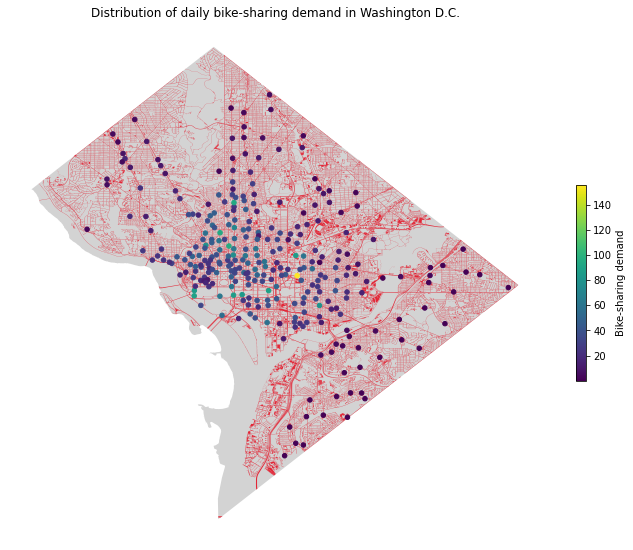

In [12]:
## draw a figure to illustrate the spatial distribution of bike demand 
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
ax.axis('off')
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
base3 = station_info.plot(column='start_ridership', ax=base2, markersize=20, 
                          #vmin = 0, vmax = 100,
                          legend_kwds={'label': "Bike-sharing demand", 'orientation': "vertical", 'shrink': 0.3},
                          legend=True)
ax.set_title('Distribution of daily bike-sharing demand in Washington D.C.')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('Distribution of daily bike-sharing demand in Washington D.C.')

In [13]:
# create a new dataframe to present hourly ridership during the whole year
sharingbikedata_hourly = pd.DataFrame(sharingbikedata[['Start station number', 'start_month', 'start_day', 'start_hour']].value_counts()).reset_index()
sharingbikedata_hourly.columns.values[-1] = 'hourly_ridership'
sharingbikedata_hourly = sharingbikedata_hourly.sort_values(['start_month', 'start_day', 'start_hour'])
sharingbikedata_hourly.head()

,Start station number,start_month,start_day,start_hour,hourly_ridership
305431,31109,1,1,0,3
353418,31321,1,1,0,3
435383,31404,1,1,0,2
451206,31126,1,1,0,2
454438,31124,1,1,0,2


Text(0, 0.5, 'Hourly bike-sharing demand')

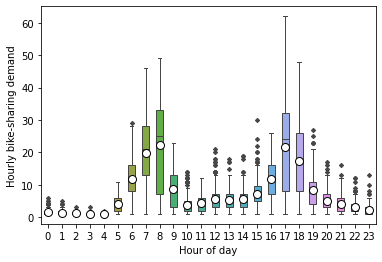

In [14]:
## draw a figure to illustrate the temporal distribution of bike demand 

# select which station
station_id_max = station_info.station_id.iloc[station_info.start_ridership.idxmax()]

# select the data
station_sel_trip = sharingbikedata_hourly.loc[sharingbikedata_hourly['Start station number'] == station_id_max]

# draw boxplot
sns.boxplot(x = 'start_hour', y = 'hourly_ridership', data = station_sel_trip,
           linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            flierprops = dict(marker='D', markersize=3),
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Hour of day')
plt.ylabel('Hourly bike-sharing demand')

Text(0, 0.5, 'Hourly bike-sharing demand')

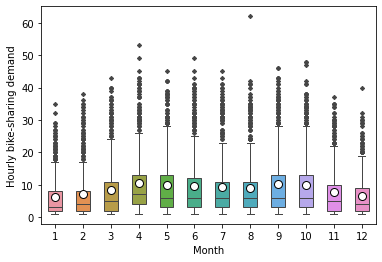

In [15]:
# draw boxplot
sns.boxplot(x = 'start_month', y = 'hourly_ridership', data = station_sel_trip,
           linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            flierprops = dict(marker='D', markersize=3),
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Month')
plt.ylabel('Hourly bike-sharing demand')

D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


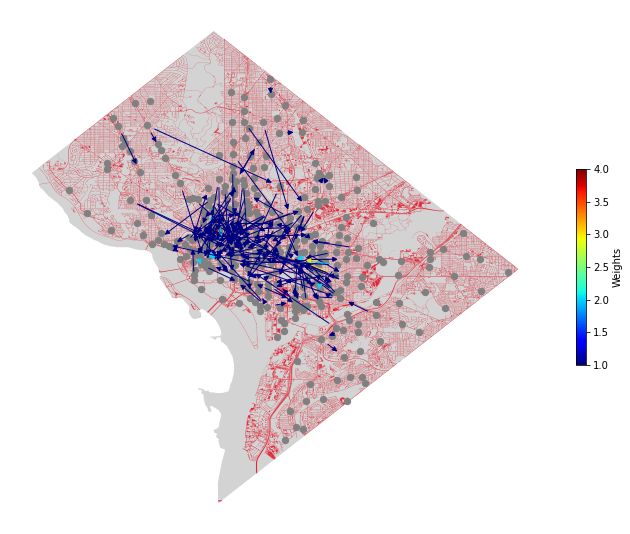

out_degree: 0.003547123780174624
out_strength: 0.6704545454545454
pagerank: 0.0028409090909090893
betweenness: 5.973277653266097e-05


In [16]:
# select one certain time period 7:00 am - 8:00 am, 03/01/19
# draw the graph: nodes, edges, and weights
start_date_030189 = datetime(2019, 3, 1, 7)
end_date_030189 = datetime(2019, 3, 1, 8)
sharing_bike_data_030189 = sharingbikedata.loc[(sharingbikedata['Start date'] >= start_date_030189) & (sharingbikedata['Start date'] <= end_date_030189)]

## calculate weights of different bike stations in a graph
weights_030189 = np.zeros((len(station_info), len(station_info)))
for i in range (len(sharing_bike_data_030189)):
    o_index = station_info[station_info['station_id'] == sharing_bike_data_030189['Start station number'].iloc[i]].index[0]
    d_index = station_info[station_info['station_id'] == sharing_bike_data_030189['End station number'].iloc[i]].index[0]
    weights_030189[o_index, d_index] = weights_030189[o_index, d_index] + 1

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
#base1 = DC_boundary.plot(ax=ax, color = 'white', edgecolor = 'black') # color='#d3d3d3'
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
station_info.plot(column='Bike_Stop', ax=base1, markersize=40, color='grey', legend=True)
plt.axis('off')

## draw directed graph

G = nx.DiGraph()
initialpos = {0:station_info.geometry.iloc[0]}
for i in range (1, len(station_info)):
    initialpos.update({i:station_info.geometry.iloc[i]})

initialpos = {k: (v.x, v.y) for k, v in initialpos.items()}
nodes = nx.draw_networkx_nodes(G, initialpos, node_size = 100)
node_index_nonzeros = []
G_weighted_edge = []
for i in range(len(station_info)):
    for j in range(len(station_info)):
        if weights_030189[i][j] != 0:
            G_weighted_edge.append((i, j, int(weights_030189[i][j])))
            node_index_nonzeros.append(i)
            node_index_nonzeros.append(j)
G.add_weighted_edges_from(G_weighted_edge)
node_index_nonzeros = list(set(node_index_nonzeros))
station_info.iloc[node_index_nonzeros].plot(ax=base3, markersize=400, marker='o', facecolors='none', edgecolors='grey')
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
edges = nx.draw_networkx_edges(G, initialpos, edge_color=edge_colors, width=1, edge_cmap=plt.cm.jet) # Blues
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet)
sm.set_array(edge_colors)
plt.colorbar(sm, label = "Weights", orientation = "vertical", shrink = 0.3)
plt.show()

## statistical metrics

# degree
graph_out_degree = nx.out_degree_centrality(G)
print('out_degree:', sum(graph_out_degree.values())/len(station_info))

# strength
graph_out_strength = []
for i in node_index_nonzeros:
    graph_out_strength.append(np.sum([d['weight'] for u, v, d in G.out_edges(i, data=True)]))
print('out_strength:', sum(np.array(graph_out_strength))/len(station_info))
    
# pagerank
graph_pagerank = nx.pagerank(G)
print('pagerank:', sum(graph_pagerank.values())/len(station_info))

# betweenness
graph_betweenness = nx.betweenness_centrality(G, normalized=True, endpoints=False)
print('betweenness:', sum(graph_betweenness.values())/len(station_info))

In [17]:
## merge data set into a new one ready for regression model
sharingbikedata_hourly = pd.DataFrame(sharingbikedata[['Start station number', 'start_month', 'start_day', 'start_hour']].value_counts()).reset_index()
sharingbikedata_hourly.columns.values[-1] = 'hourly_ridership'
sharingbikedata_hourly = sharingbikedata_hourly.sort_values(['start_month', 'start_day', 'start_hour'])
sharingbikedata_hourly = sharingbikedata_hourly.merge(station_info[['station_id', 'pop_den', 'housing_unit_den', 'transit_stop_num', 'LU_diversity', 'bike_density']],
                                                      how = 'left',
                                                      left_on = 'Start station number',
                                                      right_on = 'station_id')
sharingbikedata_hourly = sharingbikedata_hourly.drop(columns = {'Start station number'}, axis = 1)
sharingbikedata_hourly['start_time'] = sharingbikedata_hourly['start_month']
for i in range(len(sharingbikedata_hourly)):
    sharingbikedata_hourly['start_time'].iloc[i] = datetime(2019, sharingbikedata_hourly['start_month'].iloc[i], 
                                                                  sharingbikedata_hourly['start_day'].iloc[i],
                                                                  sharingbikedata_hourly['start_hour'].iloc[i])
sharingbikedata_hourly.head()

C:\Users\Kaifa Lu\AppData\Local\Temp\ipykernel_19944\2247347152.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sharingbikedata_hourly['start_time'].iloc[i] = datetime(2019, sharingbikedata_hourly['start_month'].iloc[i],


,start_month,start_day,start_hour,hourly_ridership,station_id,pop_den,housing_unit_den,transit_stop_num,LU_diversity,bike_density,start_time
0,1,1,0,3,31109.0,0.008448,4.366028e-03,34.0,2.424087,0.329663,2019-01-01 00:00:00
1,1,1,0,3,31321.0,0.000002,4.605304e-07,15.0,1.585218,1.000000,2019-01-01 00:00:00
2,1,1,0,2,31404.0,0.005327,2.580840e-03,23.0,1.933002,0.232220,2019-01-01 00:00:00
3,1,1,0,2,31126.0,0.012895,6.989163e-03,32.0,1.815027,0.325818,2019-01-01 00:00:00
4,1,1,0,2,31124.0,0.013170,7.600790e-03,34.0,1.914395,0.229339,2019-01-01 00:00:00


In [18]:
day_list_2019 = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
standard_time_series = []
for month in range(1, 13):
    for day in range(1, day_list_2019[month-1]+1):
        for hour in range (24):
            standard_time_series.append(datetime(2019, month, day, hour))
standard_time_series = pd.DataFrame({'Time': np.array(standard_time_series)})
standard_time_series['Time'] = pd.to_datetime(standard_time_series['Time'])

for i in range (len(station_info)):
    station_year_data = sharingbikedata_hourly[['start_time', 'hourly_ridership']].loc[sharingbikedata_hourly['station_id'] == station_info['station_id'].iloc[i]]
    station_year_data['start_time'] = pd.to_datetime(station_year_data['start_time'])
    standard_time_series = standard_time_series.merge(station_year_data, 
                                                      how = 'left',
                                                      left_on = 'Time',
                                                      right_on = 'start_time')
    standard_time_series = standard_time_series.fillna(0.0)
    standard_time_series = standard_time_series.rename(columns = {'hourly_ridership': station_info['station_id'].iloc[i]})
    standard_time_series = standard_time_series.drop(columns = {'start_time'}, axis = 1)
    
standard_time_series.head()

,Time,31100.0,31101.0,31102.0,31104.0,31105.0,31106.0,31107.0,31108.0,31109.0,...,31819.0,31820.0,31822.0,31823.0,31824.0,31825.0,31826.0,31827.0,31828.0,32901.0
0,2019-01-01 00:00:00,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 01:00:00,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-01 02:00:00,0.0,3.0,4.0,0.0,2.0,1.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-01 03:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01 04:00:00,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
ridership_array = standard_time_series.iloc[:, 1:] # 8760*352

for i in range (len(ridership_array)):
    ridership_array.values[i,:] = ridership_array.values[i,:] + np.random.rand(ridership_array.shape[1])/1e6

# geographical weight based on physical proximity
geographical_weight_station = np.zeros((len(station_info), len(station_info)))
for i in range (len(station_info)):
    for j in range (i+1, len(station_info)):
        geographical_weight_station[i,j] = 1000/station_geometry.iloc[i][0].distance(station_geometry.iloc[j][0]) #1/(dist/1000)
geographical_weight_station = geographical_weight_station + geographical_weight_station.T # 352*352
# gw_ridership = np.dot(ridership_array.values, geographical_weight_station)

from sklearn.preprocessing import normalize

gw_normalized = normalize(geographical_weight_station, norm='l1')/10


import libpysal

# define two kinds of spatial relationship, along with weight matrix
neighbors = {}
gw_weights = {}
for i in range(len(station_info)):
    aa = list(np.arange(len(station_info)))
    aa.remove(i)
    neighbors[i] = aa
    bb = list(gw_normalized[i, :])
    bb.remove(0)
    gw_weights[i] = bb

# Create a PySAL W object with the neighbors and weights
gw_w = libpysal.weights.W(neighbors, weights = gw_weights)

In [20]:
# draw the graph: nodes, edges, and weights
day_list_2019 = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
strength_array = ridership_array.copy()
degree_array = ridership_array.copy()
pagerank_array = ridership_array.copy()
betweenness_array = ridership_array.copy()
index = 0
for month in range(1, 13):
    for day in range(1, day_list_2019[month-1]+1):
        for hour in range (24):
            start_date = datetime(2019, month, day, hour)
            end_date = start_date + timedelta(hours = 1)
            sharing_bike_data = sharingbikedata.loc[(sharingbikedata['Start date'] >= start_date) & (sharingbikedata['Start date'] <= end_date)]

            ## calculate weights of different bike stations in a graph
            weights = np.zeros((len(station_info), len(station_info)))
            for i in range (len(sharing_bike_data)):
                o_index = station_info[station_info['station_id'] == sharing_bike_data['Start station number'].iloc[i]].index[0]
                d_index = station_info[station_info['station_id'] == sharing_bike_data['End station number'].iloc[i]].index[0]
                weights[o_index, d_index] = weights[o_index, d_index] + 1

            ## draw directed graph

            G = nx.DiGraph()
            node_index_nonzeros = []
            G_weighted_edge = []
            for i in range(len(station_info)):
                for j in range(len(station_info)):
                    if weights[i][j] != 0:
                        G_weighted_edge.append((i, j, int(weights[i][j])))
                        node_index_nonzeros.append(i)
                        node_index_nonzeros.append(j)
            G.add_weighted_edges_from(G_weighted_edge)
            node_index_nonzeros = list(set(node_index_nonzeros))

            ## statistical metrics

            # degree
            graph_out_degree = nx.out_degree_centrality(G)
            degree = np.zeros(len(station_info))
            degree[node_index_nonzeros] = list(graph_out_degree.values())
            degree_array.iloc[index, :] = degree

            # strength
            graph_out_strength = []
            for i in node_index_nonzeros:
                graph_out_strength.append(np.sum([d['weight'] for u, v, d in G.out_edges(i, data=True)]))
            strength = np.zeros(len(station_info))
            strength[node_index_nonzeros] = np.array(graph_out_strength)
            strength_array.iloc[index, :] = strength
            
            # pagerank
            graph_pagerank = nx.pagerank(G)
            pagerank = np.zeros(len(station_info))
            pagerank[node_index_nonzeros] = list(graph_pagerank.values())
            pagerank_array.iloc[index, :] = pagerank

            # betweenness
            graph_betweenness = nx.betweenness_centrality(G, normalized=True, endpoints=False)
            betweenness = np.zeros(len(station_info))
            betweenness[node_index_nonzeros] = list(graph_betweenness.values())
            betweenness_array.iloc[index, :] = betweenness
            
            index += 1


In [159]:
# regression model (based on single time period but for all bike stations)

for i in range (len(ridership_array)):
    degree_array.values[i,:] = degree_array.values[i,:] + np.random.rand(ridership_array.shape[1])/1e8
    pagerank_array.values[i,:] = pagerank_array.values[i,:] + np.random.rand(ridership_array.shape[1])/1e8
    betweenness_array.values[i,:] = betweenness_array.values[i,:] + np.random.rand(ridership_array.shape[1])/1e8

date_num = 300
order_step = 168
# extract one single station
station_spatial_reg = pd.DataFrame({'demand_pred': ridership_array.values[date_num-1, :],
                                 #'gw_spatial_lag': gw_ridership[:,0],
                                 #'be_spatial_lag': be_ridership[:,0],
                                 'degree': degree_array.values[date_num-2, :],
                                 #'strength': strength_array.values[date_num-2, :],
                                 'pagerank': pagerank_array.values[date_num-2, :],
                                 'betweenness': betweenness_array.values[date_num-2, :],
                                 'pop_density': station_info['pop_den'],
                                 'housing_unit_den': station_info['housing_unit_den'],
                                 'LU_diversity': station_info['LU_diversity'],
                                 'transit_stop_num': station_info['transit_stop_num'],
                                 'bike_density': station_info['bike_density']})
station_spatial_reg = station_spatial_reg.values
for i in range (order_step):
    station_spatial_reg = np.append(station_spatial_reg, ridership_array.values[date_num-i-2, :].reshape(-1, 1), axis=1)
station_spatial_reg.shape

(352, 177)

In [160]:
import numpy as np
import pandas as pd
import libpysal as ps
from spreg import GM_Lag
from sklearn.linear_model import LassoCV

# Load data
X = station_spatial_reg[:, 1:]
y = station_spatial_reg[:, 0]

# Construct spatial weights matrix
w = gw_w # ps.weights.KNN.from_dataframe(data, k=5)

# Create spatial vector autoregressive Lasso model
model = GM_Lag(y, X, w=w)

# Fit model with Lasso regularization using cross-validation
alphas = np.logspace(-4, 2, num=100)
lasso_cv = LassoCV(alphas=alphas, cv=10)
lasso_cv.fit(model.x, model.y)

# Print optimal value of alpha
print(lasso_cv.alpha_)

# Evaluate model performance
pred = lasso_cv.predict(model.x)
mse = np.mean((pred - model.y.reshape(1,-1)[0]) ** 2)
print(mse)

print(lasso_cv.coef_)
#print(lasso_cv.mse_path_)

0.026560877829466867
0.0872449321075372
[ 0.          0.          0.         -0.          0.          0.
 -0.          0.00050353 -0.          0.0277416   0.          0.
 -0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.         -0.          0.
  0.          0.         -0.         -0.         -0.00164078 -0.00508236
  0.02246266  0.02118815  0.          0.         -0.          0.
 -0.         -0.         -0.         -0.          0.         -0.
  0.          0.          0.          0.          0.          0.02535062
 -0.          0.          0.         -0.         -0.          0.
  0.          0.          0.          0.          0.00219685 -0.
  0.          0.00087985 -0.          0.          0.         -0.
  0.          0.          0.          0.         -0.         -0.
  0.         -0.01606319 -0.         -0.         -0.          0.
 -0.          0.          0.01543106  0.05943586  0.          0.00835134
 -0.         -0.          

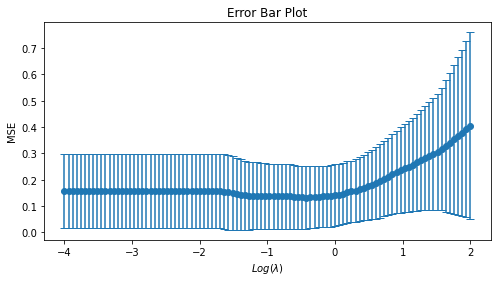

In [161]:
alphas = np.logspace(-4, 2, num=100)
CV_alphas_output = lasso_cv.mse_path_
CV_alphas_mean = np.mean(CV_alphas_output, axis = 1)
CV_alphas_std = np.std(CV_alphas_output, axis = 1)

# Plot the data with error bars
plt.figure (figsize = (8,4))
plt.errorbar(np.log10(alphas), CV_alphas_mean, yerr = CV_alphas_std, fmt='o', capsize=4)

lamda = r'$ Log(\lambda$)'

# Add labels and a title
plt.xlabel(f'{lamda}')
plt.ylabel('MSE')
plt.title('Error Bar Plot')

# Show the plot
plt.show()

In [150]:
# regression model

import warnings
warnings.filterwarnings('ignore')

order_step = 168
mse_dataset = []
coef_dataset = []
pred_dataset = []
for i in range (order_step, len(ridership_array)):
    station_spatial_reg = pd.DataFrame({'demand_pred': ridership_array.values[i, :],
                                     #'gw_spatial_lag': gw_ridership[:,0],
                                     #'be_spatial_lag': be_ridership[:,0],
                                     'degree': degree_array.values[i-1, :],
                                     #'strength': strength_array.values[i, :],
                                     'pagerank': pagerank_array.values[i-1, :],
                                     'betweenness': betweenness_array.values[i-1, :],
                                     'pop_density': station_info['pop_den'],
                                     'housing_unit_den': station_info['housing_unit_den'],
                                     'LU_diversity': station_info['LU_diversity'],
                                     'transit_stop_num': station_info['transit_stop_num'],
                                     'bike_density': station_info['bike_density']})
    station_spatial_reg = station_spatial_reg.values
    for j in range (order_step):
        station_spatial_reg = np.append(station_spatial_reg, ridership_array.values[i-j-1, :].reshape(-1, 1), axis=1)

    # Load data
    X = station_spatial_reg[:, 1:]
    y = station_spatial_reg[:, 0]

    print(i)

    # Construct spatial weights matrix
    w = gw_w # ps.weights.KNN.from_dataframe(data, k=5)

    # Create spatial vector autoregressive Lasso model
    model = GM_Lag(y, X, w=w)

    # Fit model with Lasso regularization using cross-validation
    alphas = np.logspace(-4, 2, num=100)
    lasso_cv = LassoCV(alphas=alphas, cv=10)
    lasso_cv.fit(model.x, model.y)

    # Evaluate model performance
    pred = lasso_cv.predict(model.x)
    pred_dataset.append(list(pred))
    
    mse = np.mean((pred - model.y.reshape(1,-1)[0]) ** 2)
    mse_dataset.append(mse)

    coef_dataset.append(list(lasso_cv.coef_))

168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417


1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172


3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811


5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450


6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089


8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728


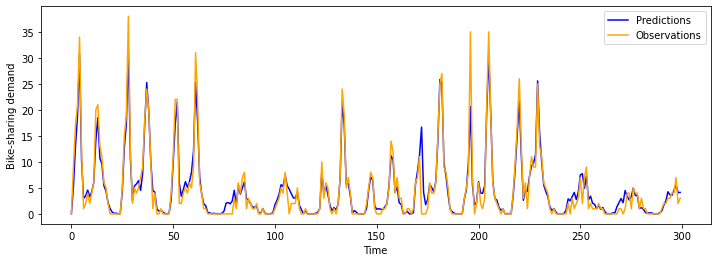

In [176]:
pred_dataset = np.array(pred_dataset)
plt.figure(figsize = (12, 4))
l1 = plt.plot(pred_dataset[700:1000,station_info.start_ridership.idxmax()], 'blue')
l2 = plt.plot(ridership_array.values[700+168:1000+168, station_info.start_ridership.idxmax()], 'orange')
plt.xlabel('Time')
plt.ylabel('Bike-sharing demand')
plt.legend(['Predictions', 'Observations'])
plt.show()

Text(0, 0.5, 'Probability density')

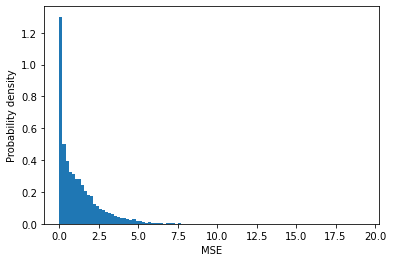

In [151]:
mse_dataset = np.array(mse_dataset)
l1 = plt.hist(mse_dataset, bins = 100, density = True)
plt.xlabel('MSE')
plt.ylabel('Probability density')

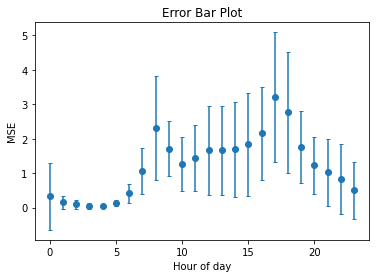

In [152]:
mse_dataset_plot = mse_dataset.reshape((358,24))
mse_dataset_plot_mean = np.mean(mse_dataset_plot, axis = 0)
mse_dataset_plot_std = np.std(mse_dataset_plot, axis = 0)
plt.errorbar(np.arange(24), mse_dataset_plot_mean, yerr = mse_dataset_plot_std, fmt='o', capsize=2)

# Add labels and a title
plt.xlabel('Hour of day')
plt.ylabel('MSE')
plt.title('Error Bar Plot')

# Show the plot
plt.show()

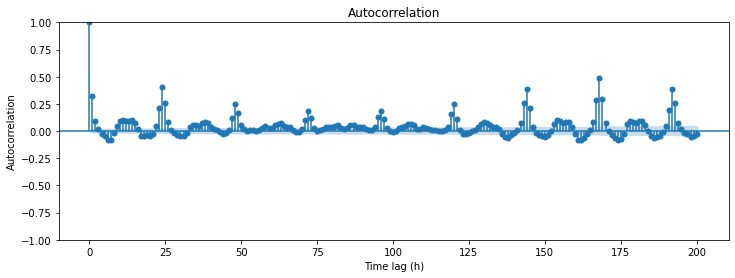

In [153]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# create some sample data
x = np.random.normal(size=100)

# plot the ACF
fig, ax = plt.subplots(figsize=(12, 4))
sm.graphics.tsa.plot_acf(ridership_array.values[:, 10], lags = 200, ax=ax)
plt.xlabel('Time lag (h)')
plt.ylabel('Autocorrelation')
plt.show()

(8592, 177)


Text(0.5, 1.0, 'Percentage of non-zero coefficients')

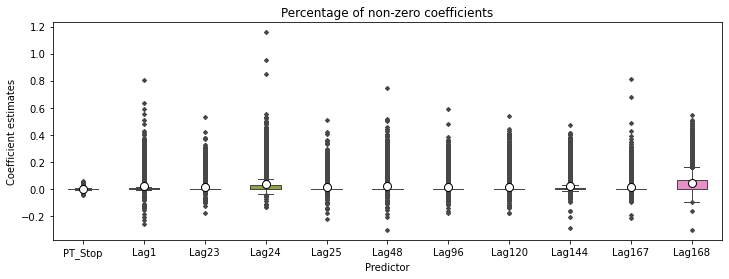

In [155]:
# count the number of non-zero for all independent variables: 
# constant (1) + graph variables (3) + spatial variables (5) + temporal (168)

coef_dataset = np.array(coef_dataset)

non_zero_count = []
for i in range (coef_dataset.shape[1]):
    non_zero_count.append(np.sum(coef_dataset[:, i] != 0))
non_zero_count = np.array(non_zero_count)
index_list_nonzero = np.where(non_zero_count > 1718.4)
print(coef_dataset.shape)
index_list_nonzero[0]

data_coef_est = pd.DataFrame({'PT_Stop': coef_dataset[:, index_list_nonzero[0][0]],
                              'Lag1': coef_dataset[:, index_list_nonzero[0][1]],
                              'Lag23': coef_dataset[:, index_list_nonzero[0][2]],
                              'Lag24': coef_dataset[:, index_list_nonzero[0][3]],
                              'Lag25': coef_dataset[:, index_list_nonzero[0][4]],
                              'Lag48': coef_dataset[:, index_list_nonzero[0][5]],
                              'Lag96': coef_dataset[:, index_list_nonzero[0][6]],
                              'Lag120': coef_dataset[:, index_list_nonzero[0][7]],
                              'Lag144': coef_dataset[:, index_list_nonzero[0][8]],
                              'Lag167': coef_dataset[:, index_list_nonzero[0][9]],
                              'Lag168': coef_dataset[:, index_list_nonzero[0][10]]})

# draw boxplot
plt.figure(figsize = (12, 4))
sns.boxplot(data = data_coef_est,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            flierprops = dict(marker='D', markersize=3),
            #showfliers = False,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
#plt.ylim([-0.2, 0.6])
plt.xlabel('Predictor')
plt.ylabel('Coefficient estimates')
plt.title('Percentage of non-zero coefficients')

In [157]:
non_zero_count[index_list_nonzero[0]]/coef_dataset.shape[0]

array([0.70018622, 0.26990223, 0.2086825 , 0.31238361, 0.21589851,
       0.22823557, 0.20006983, 0.21904097, 0.27781657, 0.23033054,
       0.38256518])

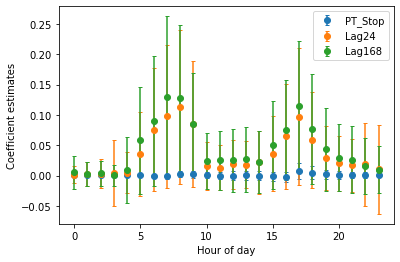

In [158]:
PTstop_dataset_plot = data_coef_est['PT_Stop'].values.reshape((358,24))
PTstop_dataset_plot_mean = np.mean(PTstop_dataset_plot, axis = 0)
PTstop_dataset_plot_std = np.std(PTstop_dataset_plot, axis = 0)
l1 = plt.errorbar(np.arange(24), PTstop_dataset_plot_mean, yerr = PTstop_dataset_plot_std, fmt='o', capsize=2)

lag24_dataset_plot = data_coef_est['Lag24'].values.reshape((358,24))
lag24_dataset_plot_mean = np.mean(lag24_dataset_plot, axis = 0)
lag24_dataset_plot_std = np.std(lag24_dataset_plot, axis = 0)
l2 = plt.errorbar(np.arange(24), lag24_dataset_plot_mean, yerr = lag24_dataset_plot_std, fmt='o', capsize=2)

lag168_dataset_plot = data_coef_est['Lag168'].values.reshape((358,24))
lag168_dataset_plot_mean = np.mean(lag168_dataset_plot, axis = 0)
lag168_dataset_plot_std = np.std(lag168_dataset_plot, axis = 0)
l3 = plt.errorbar(np.arange(24), lag168_dataset_plot_mean, yerr = lag168_dataset_plot_std, fmt='o', capsize=2)

# Add labels and a title
plt.xlabel('Hour of day')
plt.ylabel('Coefficient estimates')
#plt.title('Error Bar Plot')
plt.legend(['PT_Stop', 'Lag24', 'Lag168'])

# Show the plot
plt.show()

In [193]:
# comparison: SpVAR-LASSO Model
non_zero_count_model = []
for i in range (coef_dataset.shape[0]):
    non_zero_count_model.append(np.sum(coef_dataset[i, :] != 0))
non_zero_count_model = np.array(non_zero_count_model)
print(np.min(non_zero_count_model))
print(np.max(non_zero_count_model))
print(np.mean(non_zero_count_model))

print(np.mean(mse_dataset))

0
119
17.20495810055866
1.221153027708443


In [217]:
# Other Models

# hourly average: to calculate
average_hourly = []
for i in range (ridership_array.values.shape[1]):
    average_hourly.append(list(np.mean(ridership_array.values[:, 0].reshape((365,24)), axis = 0)))
average_hourly = np.array(average_hourly).T
average_hourly = np.array(list(average_hourly) * 358)
np.mean((average_hourly - ridership_array.values[168:, :]) ** 2)

4.638670668684257

In [242]:
# autoregression model (one single station)
from statsmodels.tsa.arima.model import ARIMA

data1 = ridership_array.values[:, 0]

model1 = ARIMA(data1, order=(24, 0, 0))  # Use an AR(168) model
result1 = model1.fit()
preds1 = result1.predict(169, ridership_array.values.shape[0])
print(np.mean((preds1 - ridership_array.values[168:, 0]) ** 2))

## arma
data2 = ridership_array.values[:, 0]

model2 = ARIMA(data2, order=(24, 1, 1))  # Use an ARMA(168) model
result2 = model2.fit()
preds2 = result2.predict(169, ridership_array.values.shape[0])
print(np.mean((preds2 - ridership_array.values[168:, 0]) ** 2))

1.7934506830185064
1.76568823993287


In [243]:
from statsmodels.tsa.arima.model import ARIMA

mse_ar = []
for i in range (ridership_array.values.shape[1]):
    data = ridership_array.values[:, i]
    print(i)
    model = ARIMA(data, order=(24, 0, 0))  # Use an AR(168) model
    result = model.fit()
    preds = result.predict(169, ridership_array.values.shape[0])
    mse_ar.append(np.mean((preds - ridership_array.values[168:, i]) ** 2))
mse_ar = np.array(mse_ar)
print(np.mean(mse_ar))

1.5340834201412255


In [244]:
mse_arma = []
for i in range (ridership_array.values.shape[1]):
    data = ridership_array.values[:, i]
    print(i)
    model = ARIMA(data, order=(24, 1, 1))  # Use an ARMA(168, 1) model
    result = model.fit()
    preds = result.predict(169, ridership_array.values.shape[0])
    mse_arma.append(np.mean((preds - ridership_array.values[168:, i]) ** 2))
mse_arma = np.array(mse_arma)
print(np.mean(mse_arma))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


LinAlgError: Schur decomposition solver error.

In [227]:
# spatial vector autoregression

from sklearn.linear_model import Lasso

order_step = 168
mse_dataset = []
coef_dataset = []

for i in range (order_step, len(ridership_array)):
    station_spatial_reg = pd.DataFrame({'demand_pred': ridership_array.values[i, :],
                                     #'gw_spatial_lag': gw_ridership[:,0],
                                     #'be_spatial_lag': be_ridership[:,0],
                                     'degree': degree_array.values[i-1, :],
                                     #'strength': strength_array.values[i, :],
                                     'pagerank': pagerank_array.values[i-1, :],
                                     'betweenness': betweenness_array.values[i-1, :],
                                     'pop_density': station_info['pop_den'],
                                     'housing_unit_den': station_info['housing_unit_den'],
                                     'LU_diversity': station_info['LU_diversity'],
                                     'transit_stop_num': station_info['transit_stop_num'],
                                     'bike_density': station_info['bike_density']})
    station_spatial_reg = station_spatial_reg.values
    for j in range (order_step):
        station_spatial_reg = np.append(station_spatial_reg, ridership_array.values[i-j-1, :].reshape(-1, 1), axis=1)

    # Load data
    X = station_spatial_reg[:, 1:]
    y = station_spatial_reg[:, 0]
    
    print(i)

    # Construct spatial weights matrix
    w = gw_w # ps.weights.KNN.from_dataframe(data, k=5)

    # Create spatial vector autoregressive Lasso model
    model = GM_Lag(y, X, w=w)
    
    lasso = Lasso(alpha=0)
    lasso.fit(model.x, model.y)

    # Evaluate model performance
    pred = lasso.predict(model.x)
    mse = np.mean((pred - model.y.reshape(1,-1)[0]) ** 2)
    mse_dataset.append(mse)
np.mean(np.array(mse_dataset))  ## 0.3273530440117832  

168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417


1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172


3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813


5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452


6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093


8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
